In [53]:
%matplotlib inline

In [68]:
import collections
import json

import pandas as pd

In [16]:
!sbt "run-main ContinuousDoubleAuction"

[info] Loading global plugins from C:\Users\pughdr\.sbt\0.13\plugins
[info] Loading project definition from C:\Users\pughdr\Research\scalabm\auctions-simulation-example\project
[info] Set current project to auctions-simulation-example (in build file:/C:/Users/pughdr/Research/scalabm/auctions-simulation-example/)
[info] Compiling 1 Scala source to C:\Users\pughdr\Research\scalabm\auctions-simulation-example\target\scala-2.12\classes...
[info] Running ContinuousDoubleAuction 
[success] Total time: 13 s, completed Jun 4, 2017 2:23:07 PM


Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=256m; support was removed in 8.0


# Load the resulting JSON data into a DataFrame

Although we can simply load the JSON data straight into Panadas, the resulting DataFrame is note terribly useful... 

In [22]:
df = pd.read_json("./output.json")

In [23]:
df.head()

,askOrder,bidOrder,price
0,{'issuer': '09636ef7-9468-4150-b5d6-4d01d9300f...,{'issuer': '2134f075-3eda-4fd6-a5a7-bf3c868fc9...,{'value': 674661567}
1,{'issuer': '0fd79076-1230-4ceb-b6ee-e5f52bd08a...,{'issuer': 'fda35b5b-0680-4bcd-8124-e557c77cd1...,{'value': 1251951003}
2,{'issuer': 'e3a7542e-6906-4bac-a58e-73cd835819...,{'issuer': '620c3355-c1e6-449b-be93-17eb406e7e...,{'value': 676518127}
3,{'issuer': 'ed804d30-d4ed-4620-8c41-39b4a8935b...,{'issuer': 'aa9a7be3-905d-40cb-9f13-236fa3db9e...,{'value': 1226922549}
4,{'issuer': '8ec8f181-3f1a-4be8-b482-616054d355...,{'issuer': '58226cfe-5c14-4e1f-acfc-fd0df9e08b...,{'value': 689170124}


In [24]:
df.tail()

,askOrder,bidOrder,price
39160,{'issuer': '87e0ea42-4bea-46b5-96c4-769056f6be...,{'issuer': '2d0499c0-b381-4c5c-92ca-afbeaa3825...,{'value': 1062494452}
39161,{'issuer': 'a16ebd7c-45ad-4cf7-8aee-6b4d9c2834...,{'issuer': 'fd16ac4b-9aae-4841-a8d4-dcf5b80f8f...,{'value': 1507087645}
39162,{'issuer': 'caa80033-dfc3-4456-bb97-aca71a7ebd...,{'issuer': '272df194-2ff5-4a2a-8a35-86fc399dcd...,{'value': 818178480}
39163,{'issuer': '442a5586-7194-4f7a-a315-b134d9a13d...,{'issuer': 'd2c2f40f-03b9-4f81-9af8-947b5cfb45...,{'value': 1995313330}
39164,{'issuer': '9d792b9e-e99c-4ee4-983a-848b8fd30c...,{'issuer': 'e5f13d29-3ecc-4724-9c60-89acbd2bbf...,{'value': 1255000031}


...we will need to massage the data into a more convenient format for analysis.  

In [37]:
with open('output.json') as f:    
    fills = json.load(f)

In [38]:
# first fill...
fills[0]

{'askOrder': {'issuer': '89ca6909-533e-4b25-8cef-fcf8ce3c8f50',
  'limit': {'value': 102948884},
  'quantity': {'value': 1},
  'tradable': {'tick': 1}},
 'bidOrder': {'issuer': '502ebcb3-597e-4b10-b034-14dc95b2a92d',
  'limit': {'value': 676262207},
  'quantity': {'value': 1},
  'tradable': {'tick': 1}},
 'price': {'value': 674661567}}

In [40]:
# ...last fill!
fills[-1]

{'askOrder': {'issuer': 'b0606dd5-b0b6-4e5b-8e26-76e5d6b5fe2b',
  'limit': {'value': 53352659},
  'quantity': {'value': 1},
  'tradable': {'tick': 1}},
 'bidOrder': {'issuer': '253db882-e9e2-4df2-abc8-fd77e2ca1ce4',
  'limit': {'value': 1911251950},
  'quantity': {'value': 1},
  'tradable': {'tick': 1}},
 'price': {'value': 154568684}}

In [69]:
# handling the fact that the stream of auction results is ordered wrong way!
parsed_json = {'ask_price': collections.deque(), 
               'bid_price': collections.deque(), 
               'fill_price': collections.deque(), 
               'spread': collections.deque()}

for fill in fills:
    ask_price = fill['askOrder']['limit']['value']
    bid_price = fill['bidOrder']['limit']['value']
    fill_price = fill['price']['value']
    spread = bid_price - ask_price
    parsed_json['ask_price'].appendleft(ask_price)
    parsed_json['bid_price'].appendleft(bid_price)
    parsed_json['fill_price'].appendleft(fill_price)
    parsed_json['spread'].appendleft(spread)

In [70]:
df = pd.DataFrame.from_dict(parsed_json)

In [71]:
df.head()

,ask_price,bid_price,fill_price,spread
0,53352659,1911251950,154568684,1857899291
1,255784709,1833529520,435358453,1577744811
2,614932197,1399541472,623761534,784609275
3,207850376,329659842,268755109,121809466
4,273324016,1595911716,339069217,1322587700


# Times series plot of price data

Ideally, we should plot the `askOrder.limit.value`, `bidOrder.limit.value`, and the `price.value` on one plot.  Should be the case that the `price.value` is a weighted average of the other two prices.

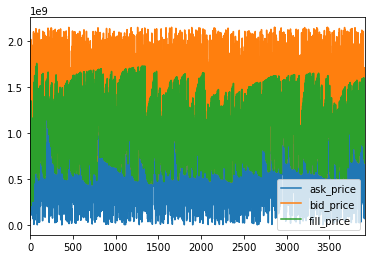

In [72]:
df[['ask_price', 'bid_price', 'fill_price']].plot();

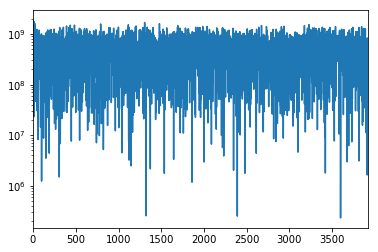

In [73]:
df.spread.plot(logy=True);

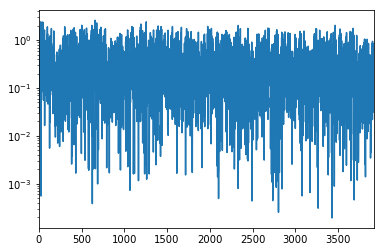

In [74]:
returns = df.fill_price.pct_change()
returns.abs().plot(logy=True);

In [26]:
# TODO: interactive timeseries plot of the data using plotly (or similar)

# Histogram of the distribution of `askOrder.limit.value`

Useful to see how we can create historgram of values across agents.  Agents are representing by `askOrder.issuer` identifiers.

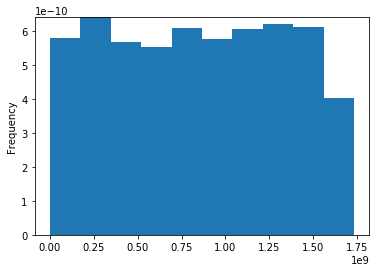

In [81]:
# limit price for ask orders was sampled from U[1, 2147483647]
df.ask_price.plot(kind='hist', normed=True)

In [27]:
# TODO: interactive histogram of the data using plotly (or similar)